# GTEx rare variants analysis

## Imports

In [1]:
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from kipoi_enformer.utils import get_tss_from_genome_annotation
import statsmodels.api as sm
import plotnine as pn
import pyranges as pr

%load_ext autoreload
%autoreload 2

2024-06-13 12:27:33.725322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 12:27:33.725401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 12:27:34.029469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 12:27:34.383834: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [4]:
pn.theme_set(pn.theme_bw())
pn.theme_update(dpi=150)

In [5]:
# GTEx variants
variant_path = '/s/project/rep/processed/training_results_v14/gtex_v8_old_dna/private_variants.parquet/rare_variants.vcf.parquet/**/*.parquet'
# OUTRIDER outlier scores on GTEx variants
outrider_path = '/s/project/rep/processed/training_results_v14/gtex_v8_old_dna/OUTRIDER_nonmissing.parquet/**/*.parquet'
# genome annotation for hg19
gtf_path = '/s/genomes/Gencode/Gencode_human/release_40/GRCh37_mapping/gencode.v40lift37.annotation.gtf.gz'

# Output path
output_path = Path('/data/nasif12/home_if12/tsi/output/gtex_analysis/')
output_path.mkdir(exist_ok=True, parents=True)

## Analysis

We are only loading ensembl canonical transcripts for this analysis. So there is 1 transcript per gene!

In [6]:
gtf_parquet_path = output_path / 'gtf.parquet'

# save gtf in parquet for faster loading
if not Path(gtf_parquet_path).exists():
    gtf_df = pr.read_gtf(gtf_path, as_df=True, duplicate_attr=True)
    gtf_df.to_parquet(gtf_parquet_path)
else:
    gtf_df = pd.read_parquet(gtf_parquet_path)

gtf_ldf = (pl.from_pandas(get_tss_from_genome_annotation(gtf_df, protein_coding_only=True, canonical_only=True)).
           rename({'gene_id': 'gene', 'transcript_id': 'transcript', 'Strand': 'strand', 'Chromosome': 'chrom'}).
           select(pl.col(['chrom', 'gene', 'transcript', 'transcript_start', 'transcript_end']), pl.col('strand').cast(pl.Categorical)).
           with_columns(pl.col('gene').str.replace(r"([^\.]+)\..+$", "${1}").alias('gene'),
                        pl.col('transcript').str.replace(r"([^\.]+)\..+$", "${1}").alias('transcript')).
           lazy())

In [7]:
outrider_ldf = pl.scan_parquet(outrider_path).select(['gene', 'individual', 'subtissue', 'padj', 'zscore', 'l2fc']). \
    rename({'subtissue': 'tissue', 'l2fc': 'l2fc_outrider'})
# set outlier_status
outrider_ldf = outrider_ldf.with_columns((pl.when(pl.col('padj') > 0.2)
                                            .then(pl.lit('normal'))
                                            .otherwise(
                                                pl.when(pl.col('zscore') > 0)
                                                    .then(pl.lit('overexpressed'))
                                                    .otherwise(
                                                        pl.when(pl.col('zscore') < 0)
                                                            .then(pl.lit('underexpressed'))
                                                            # this should never be the case
                                                            .otherwise(pl.lit('CHECK'))
                                                    )
                                            )
                                        ).cast(pl.Enum(['underexpressed', 'normal', 'overexpressed'])).alias('outlier_state'))

In [8]:
variant_ldf = pl.scan_parquet(variant_path).select(['sampleId', 'chrom', 'start', 'end', 'ref', 'alt']).rename({'sampleId': 'individual',
                                                                                                                'start': 'variant_start',
                                                                                                                'end': 'variant_end'})

### How many variants per bin around the TSS grouped by outlier status?

In [11]:
# todo might have to consider a different way of calculating the TSS distance

In [9]:
# join outrider with gtf on gene name
outrider_gtf_ldf = outrider_ldf.join(gtf_ldf, how='left', on='gene')
# join outrider with variants on individual
outrider_variant_ldf = outrider_gtf_ldf.join(variant_ldf, how='left', on=['individual', 'chrom'])
#calculate variant position relative to the tss: rel_var_pos
outrider_variant_ldf = outrider_variant_ldf.with_columns((pl.when(pl.col('strand') == '+')
                                 .then(pl.col('variant_start') - pl.col('transcript_start'))
                                 .otherwise(pl.col('transcript_end') - pl.col('variant_start'))
                            ).alias('rel_var_pos'))
# filter out variants far from the TSS (-2000, 500)
outrider_variant_ldf = outrider_variant_ldf.filter((pl.col('rel_var_pos') > -2000) & (pl.col('rel_var_pos') < 500))
outrider_variant_ldf = outrider_variant_ldf.select(['gene', 'tissue', 'individual', 'rel_var_pos', 'outlier_state', 'zscore', 'padj'])

In [11]:
# pl.Config.set_streaming_chunk_size(400)
# print(outrider_variant_ldf.explain(streaming=True))

In [13]:
# save intermediate table
outrider_variant_path = output_path / 'outrider_variant.parquet'
if not outrider_variant_path.exists():
    outrider_variant_ldf.sink_parquet(outrider_variant_path)
outrider_variant_ldf = pl.scan_parquet(outrider_variant_path)

In [14]:
# rel_var_pos in bins
cuts = list(range(-1950, 500, 50))
cut_labels = ['(-2000, -1950)'] + [f'[{cuts[i]}, {cuts[i+1]})' for i in range(len(cuts) - 1)] + ['[450, 500)']

outrider_variant_bin_ldf = outrider_variant_ldf.with_columns(
    (pl.col('rel_var_pos').cut(cuts, labels=cut_labels)).alias('rel_var_pos_bin').cast(pl.Enum(cut_labels))
)
# calculate counts per bins
outrider_variant_bin_count_ldf = outrider_variant_bin_ldf.group_by(['outlier_state', 'rel_var_pos_bin']). \
    agg(pl.len().alias('count'), pl.col('rel_var_pos').min().alias('rel_var_pos'))

# calculate mean of each bin and then sum the means in each outlier state
totals_ldf = outrider_variant_bin_count_ldf.group_by('outlier_state').agg(pl.sum('count').alias('total_count'))
# normalize each count by the mean calculated above
enrichment_ldf = outrider_variant_bin_count_ldf.join(totals_ldf, on='outlier_state').with_columns((pl.col('count') / pl.col('total_count')).alias('enrichment'))

In [15]:
enrichment_df = enrichment_ldf.collect(streaming=True)

In [16]:
ci_low, ci_high = sm.stats.proportion_confint(enrichment_df["count"], enrichment_df["total_count"])
enrichment_df = enrichment_df.with_columns(pl.Series(ci_low).alias('ci_low'), pl.Series(ci_high).alias('ci_high'))

In [17]:
total_variant_count_df = outrider_variant_bin_ldf.select(['gene', 'individual', 'rel_var_pos_bin', 'rel_var_pos']).unique().group_by(['rel_var_pos_bin']). \
    agg(pl.len().alias('count')).collect()

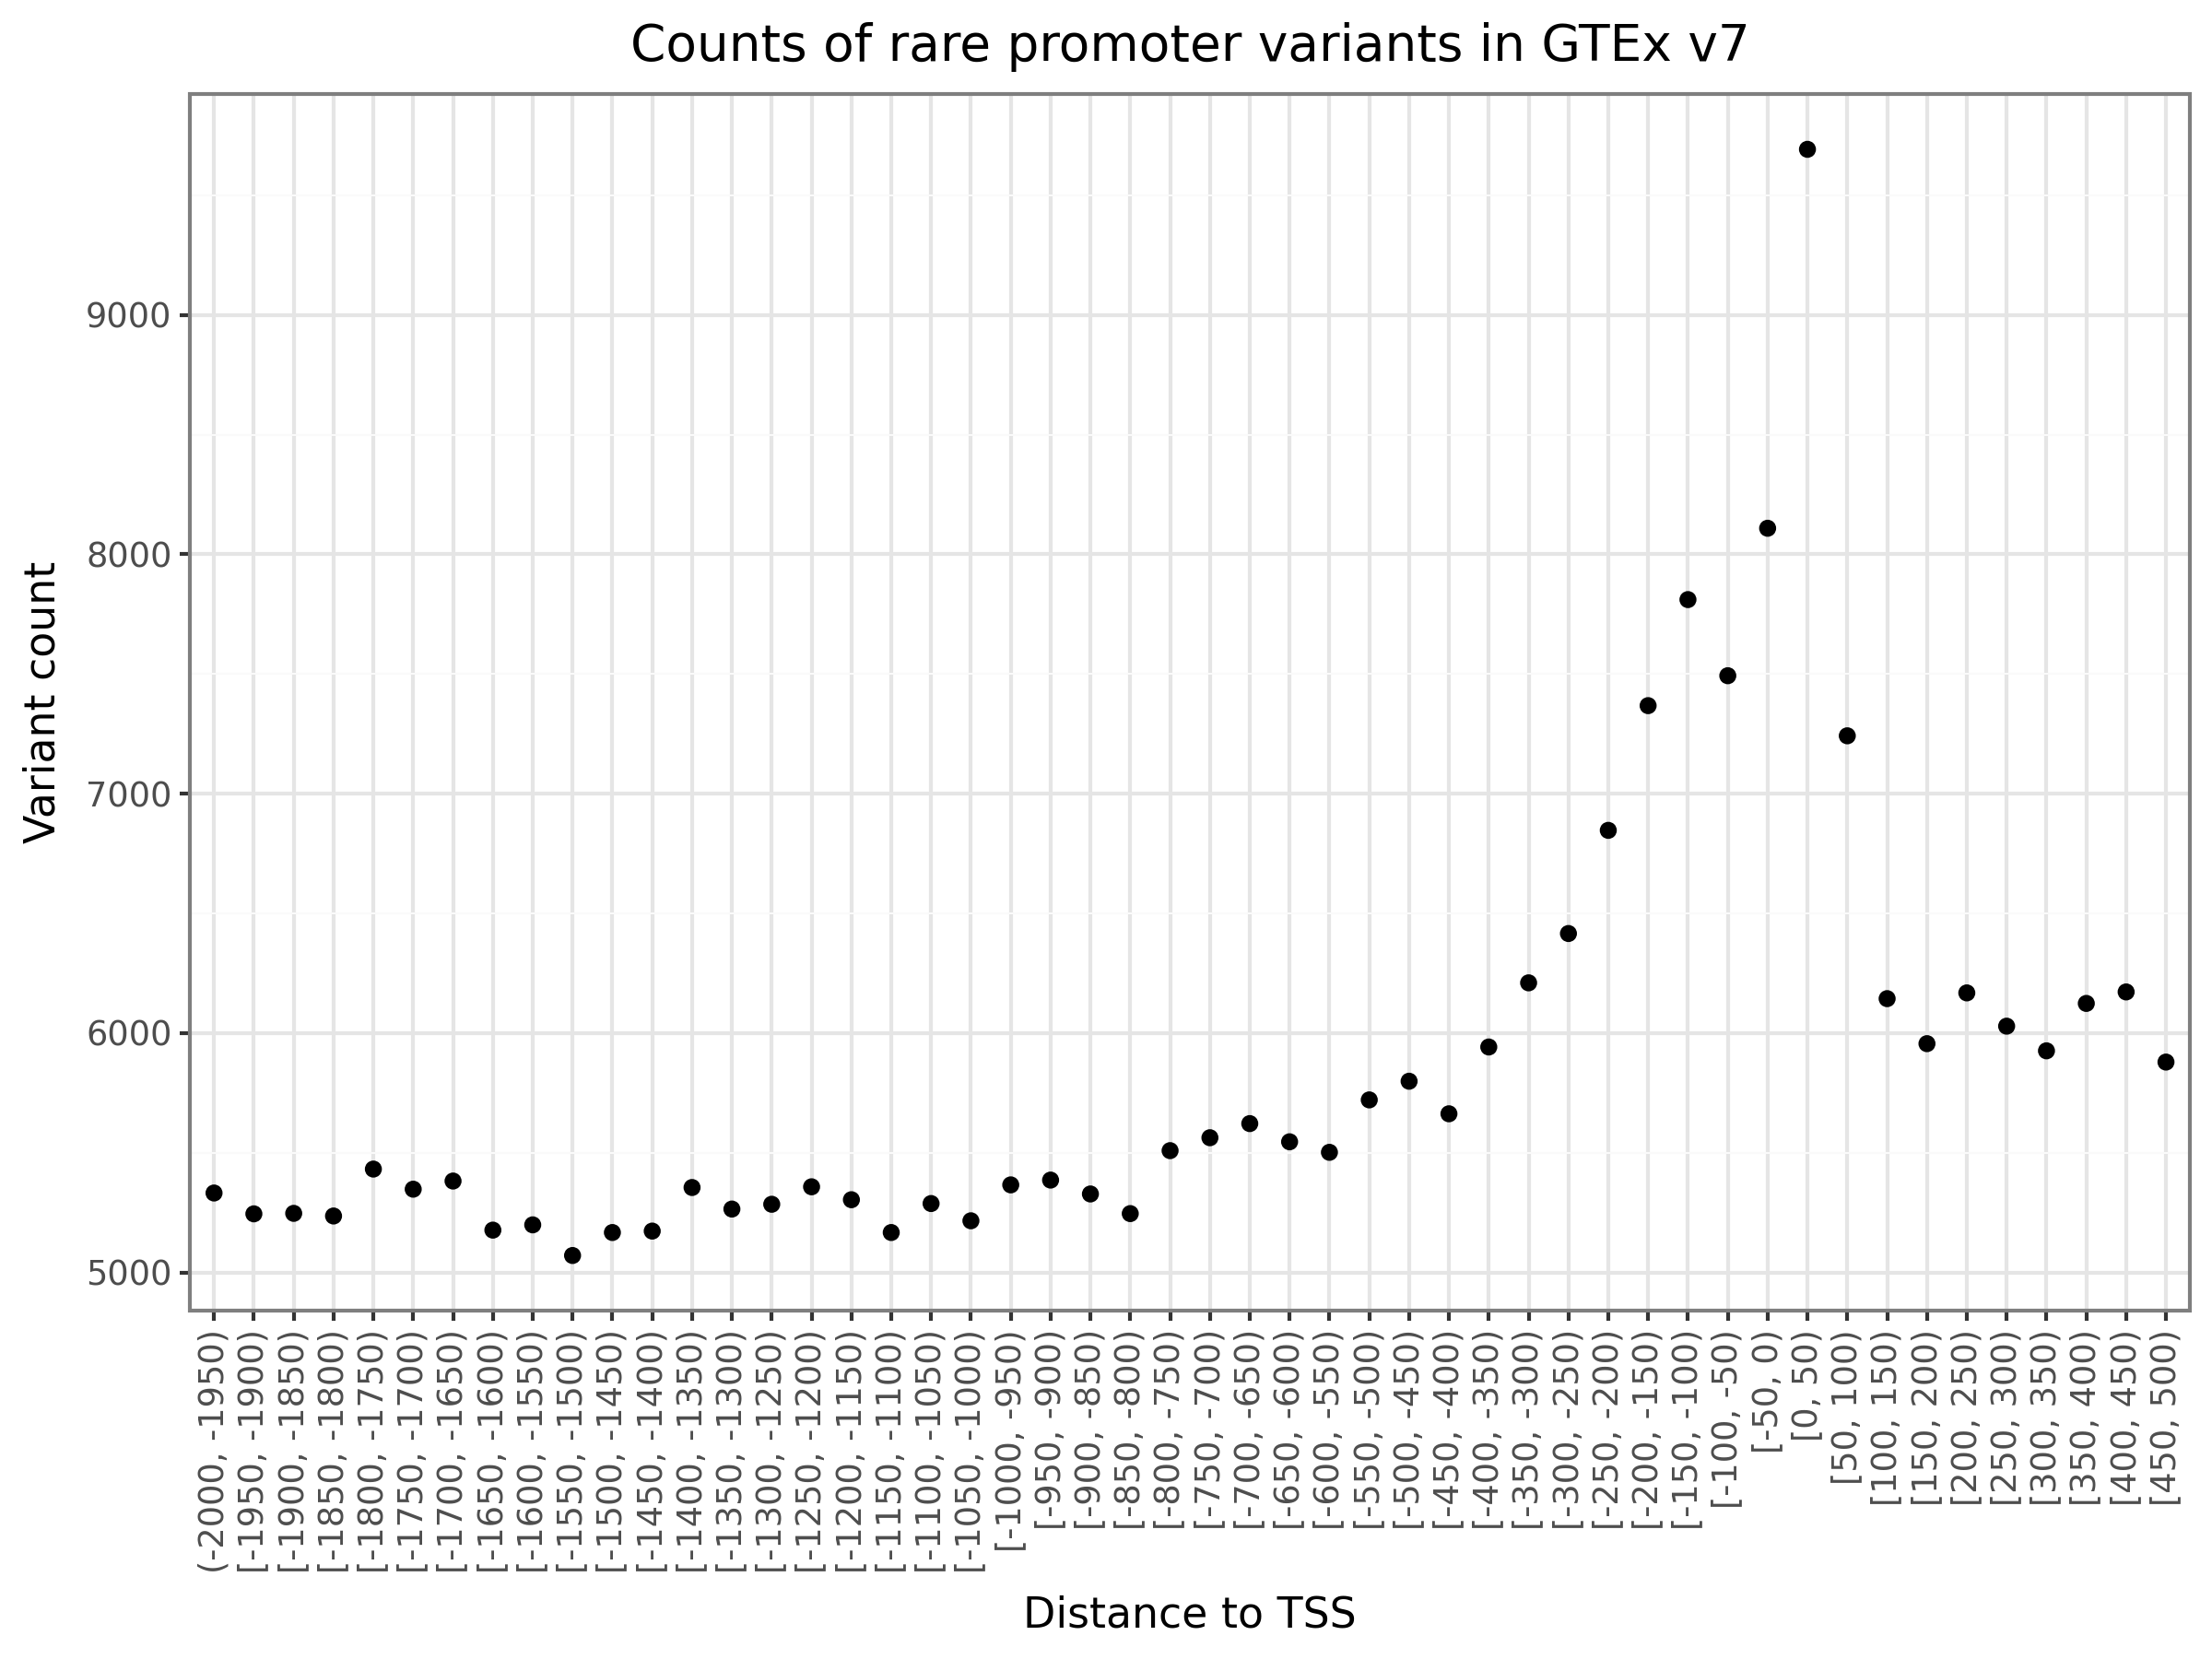

In [18]:
plot = (
    pn.ggplot(total_variant_count_df, pn.aes(x="rel_var_pos_bin", y="count"))
    + pn.geom_point()
    + pn.theme(
        figure_size=(8, 6),
        axis_text_x=pn.element_text(angle=90),
        dpi=150
    )
    + pn.labs(
        x="Distance to TSS", 
        y="Variant count",
        color="",
        fill="",
        title="Counts of rare promoter variants in GTEx v7",
    )
)

plot

In [19]:
barplot = (
    pn.ggplot(outrider_variant_bin_ldf.collect(), pn.aes(x="rel_var_pos_bin", fill="outlier_state"))
    + pn.geom_bar(position="dodge")
    + pn.theme(
        figure_size=(8, 6),
        axis_text_x=pn.element_text(angle=90),
        dpi=150
    )
    + pn.labs(
        x="Distance to TSS", 
        y="Count",
        color="",
        fill="",
        title="Count of rare promoter variants in GTEx v7",
    )
    + pn.scale_y_log10()
)

In [20]:
boxplot = (
    pn.ggplot(enrichment_df, pn.aes(x="rel_var_pos_bin", y="enrichment", fill="outlier_state", color="outlier_state"))
    + pn.geom_line(pn.aes(group="outlier_state"), linetype="dashed")
    + pn.geom_point()
    + pn.geom_errorbar(pn.aes(ymin="ci_low", ymax="ci_high"))
    + pn.theme(
        figure_size=(8, 6),
        axis_text_x=pn.element_text(angle=90),
        dpi=150
    )
    + pn.labs(
        x="Distance to TSS", 
        y="Variant enrichment",
        color="",
        fill="",
        title="Enrichment of rare promoter variants in GTEx v7",
    )
)

pn.ggsave(plot, output_path / 'variant_enrichment.pdf')
pn.ggsave(plot, output_path / 'variant_enrichment.svg')
pn.ggsave(plot, output_path / 'variant_enrichment.png', dpi=600)

/opt/modules/i12g/anaconda/envs/kipoi-enformer-george/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/modules/i12g/anaconda/envs/kipoi-enformer-george/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /data/nasif12/home_if12/tsi/output/gtex_analysis/variant_enrichment.pdf
/opt/modules/i12g/anaconda/envs/kipoi-enformer-george/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/modules/i12g/anaconda/envs/kipoi-enformer-george/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /data/nasif12/home_if12/tsi/output/gtex_analysis/variant_enrichment.svg
/opt/modules/i12g/anaconda/envs/kipoi-enformer-george/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/opt/modules/i12g/anaconda/envs/kipoi-enformer-george/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /data/nasif12

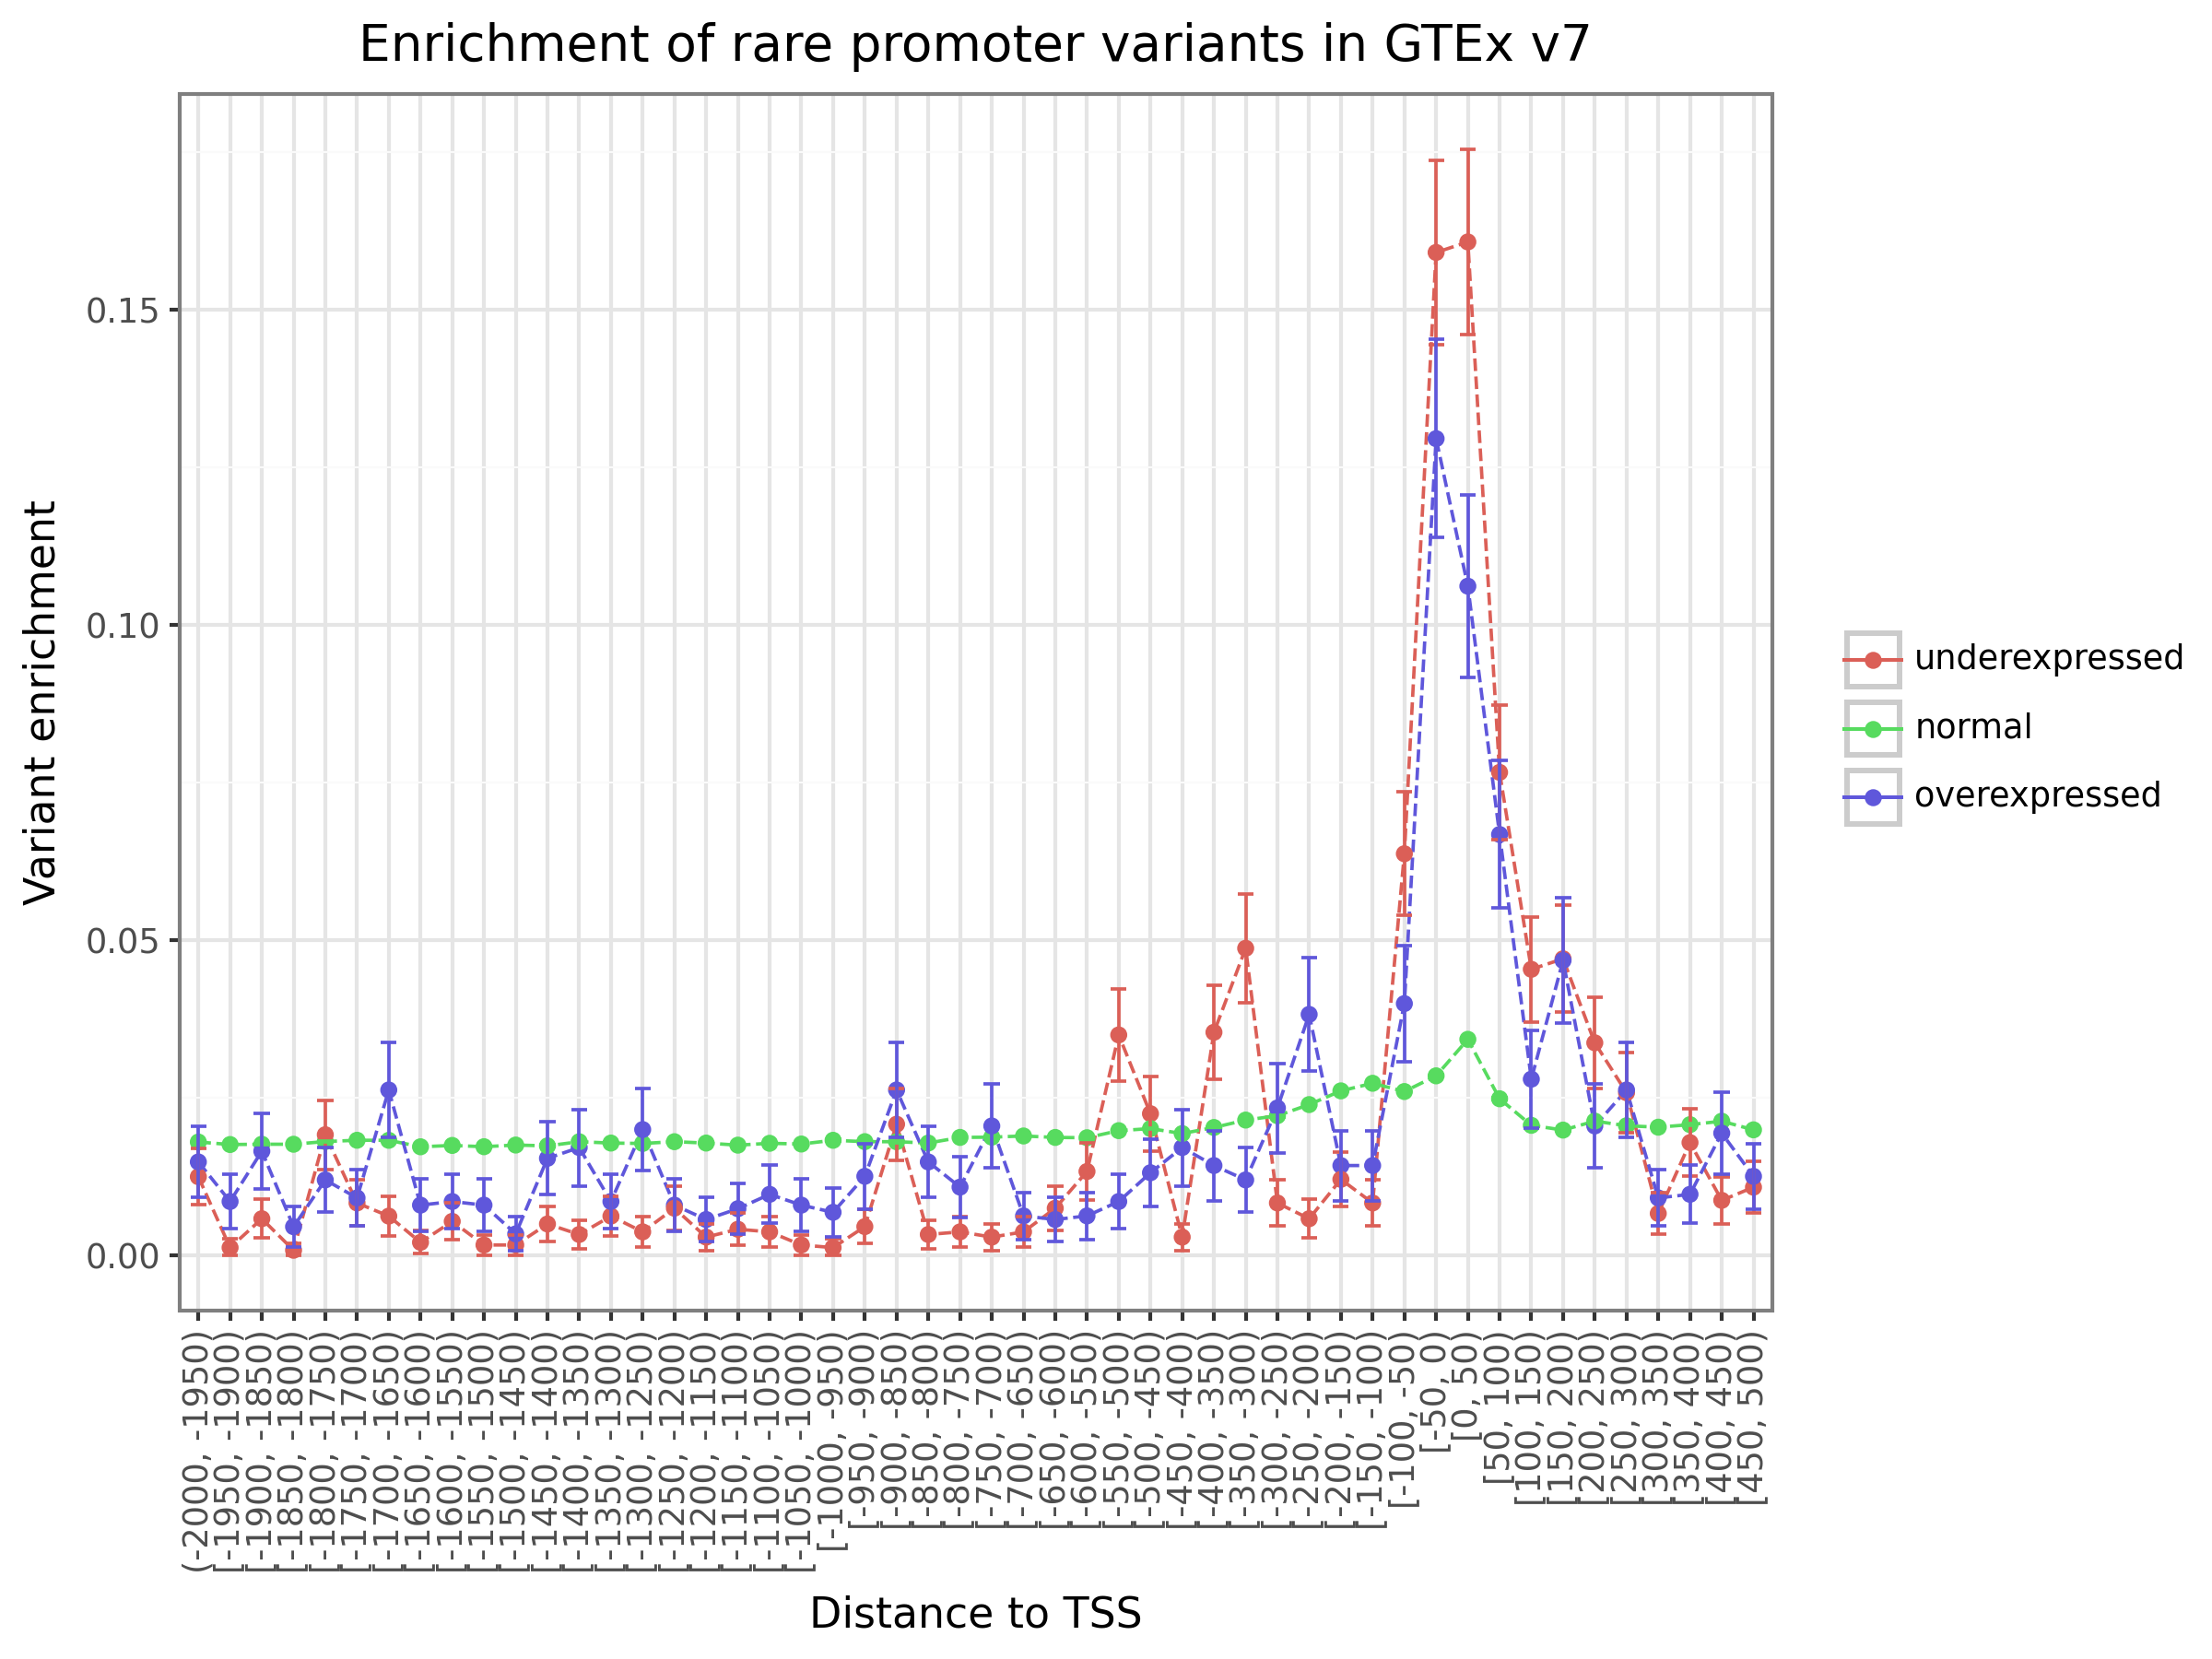

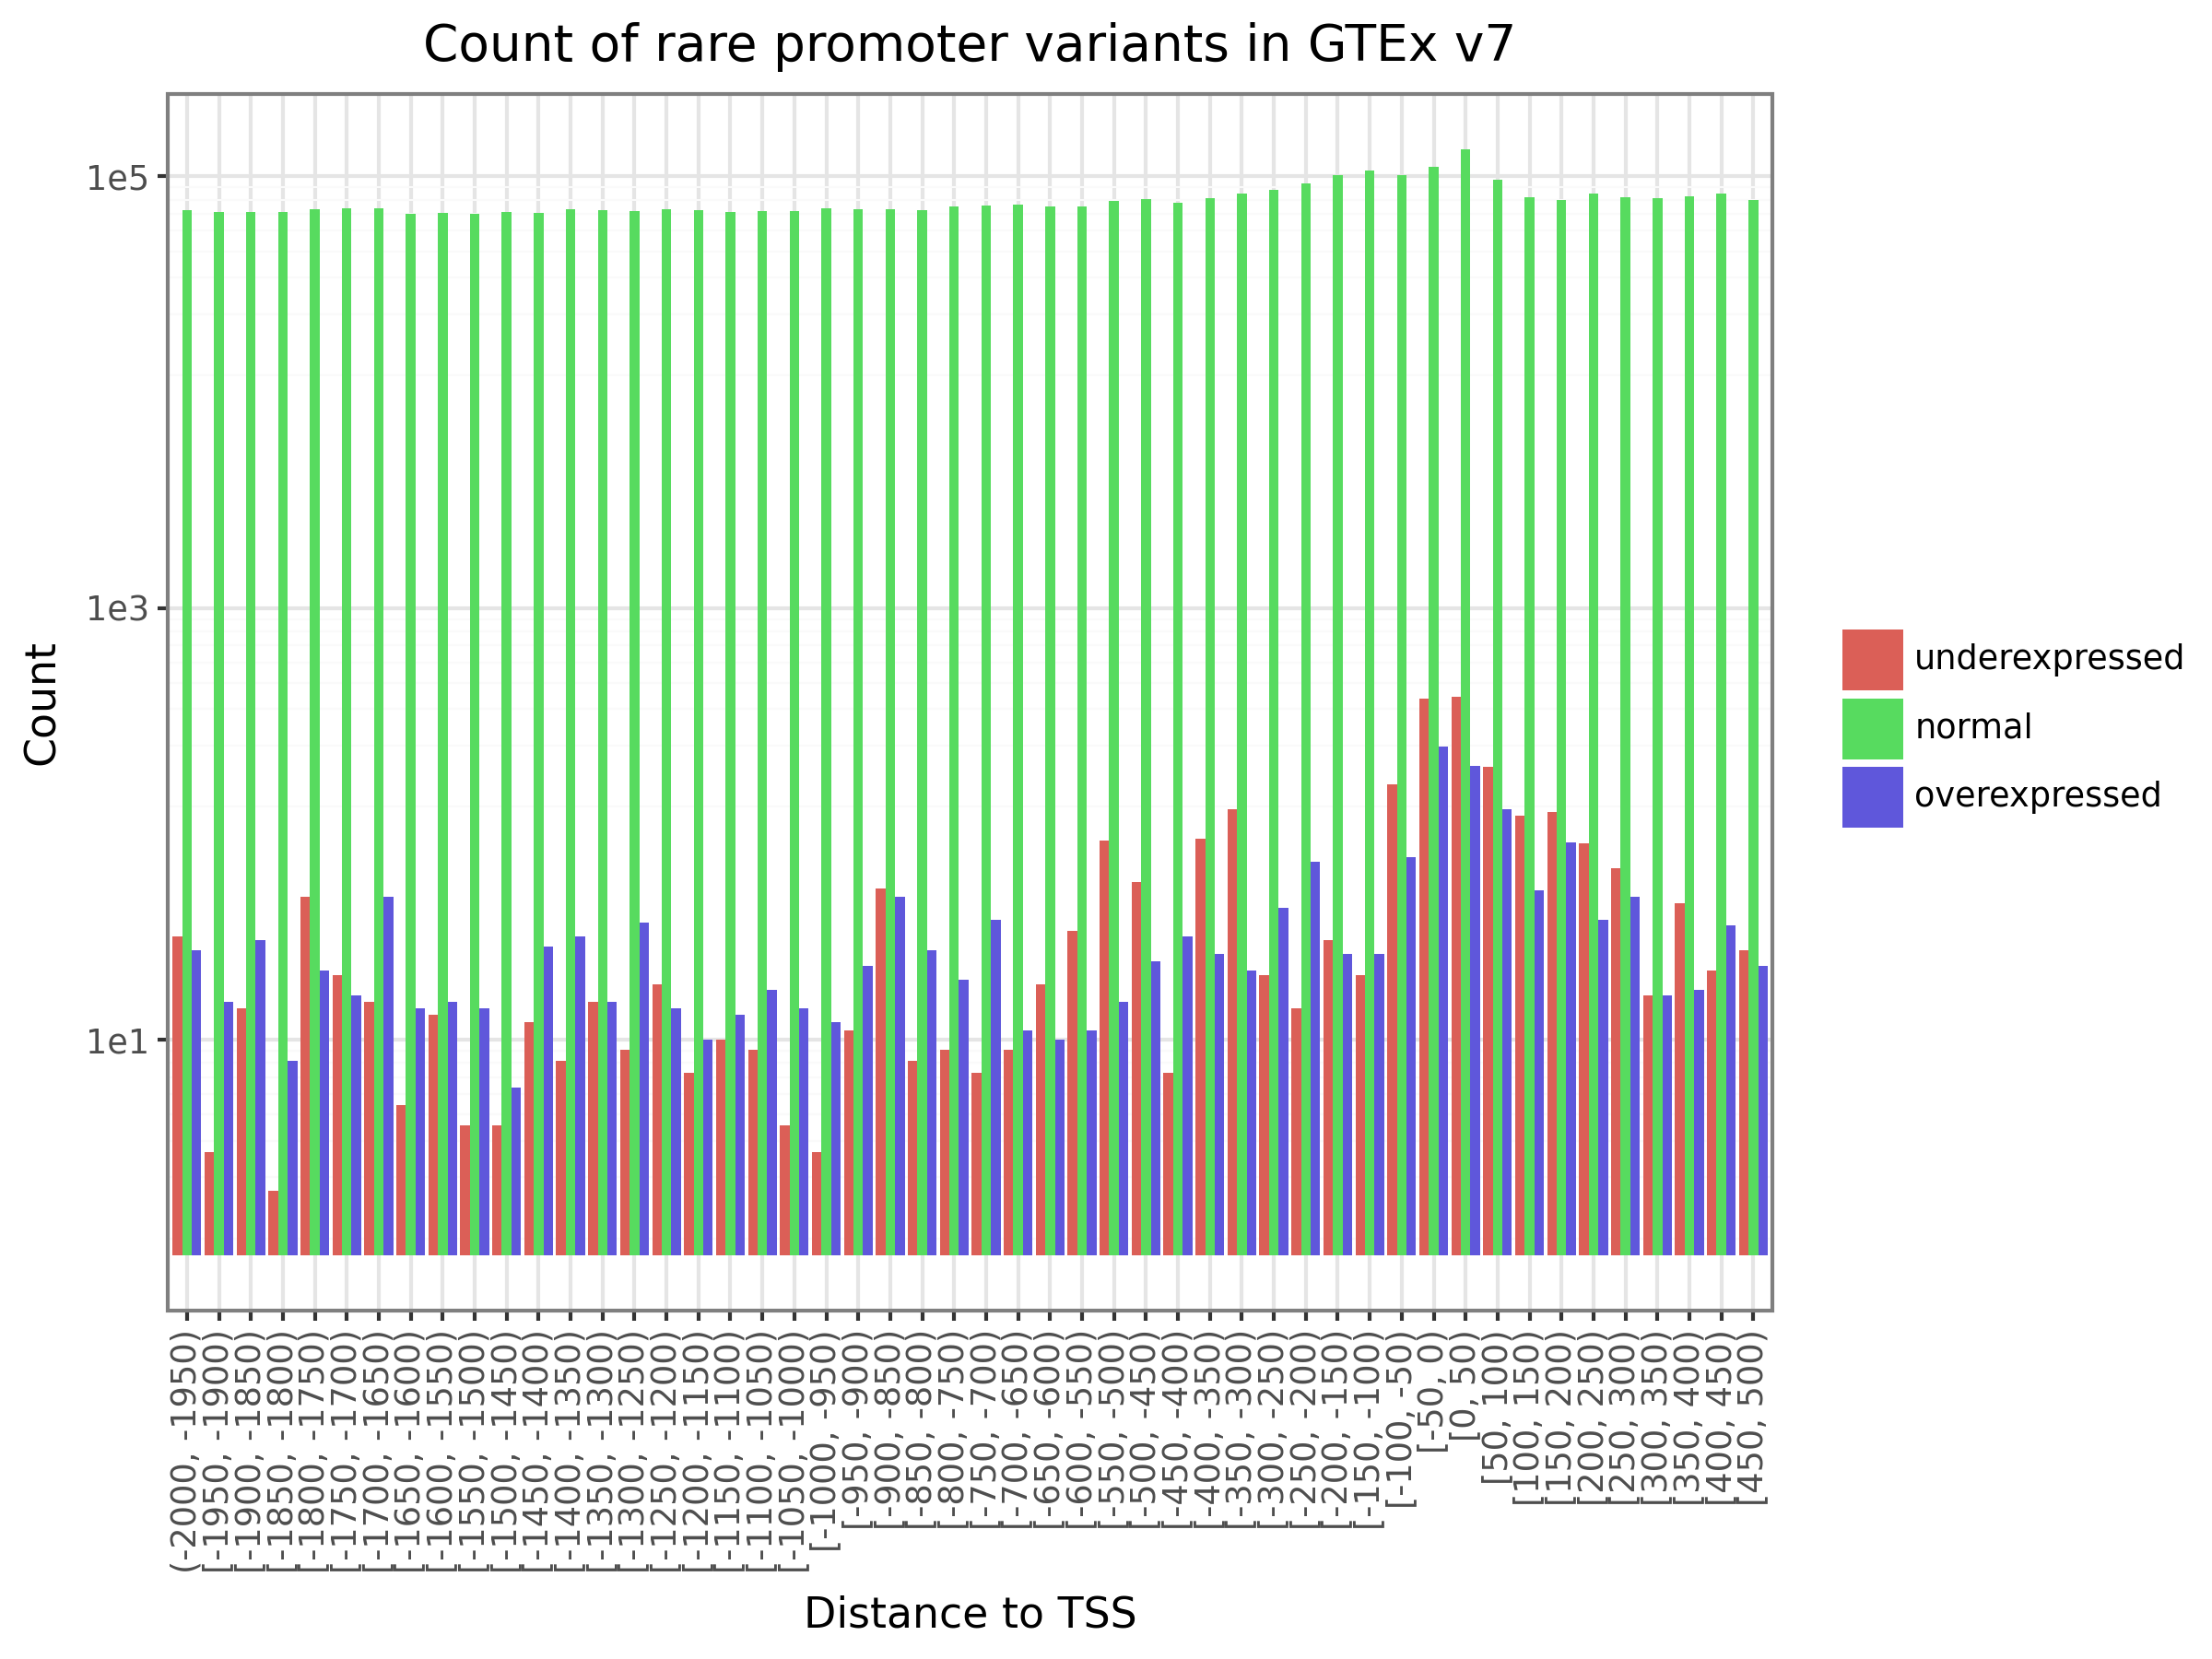

In [21]:
boxplot.show()
barplot.show()